# This notebook lays out the process of importing lightcurve data and (using an MCMC) fitting a transit model to that data, given a set of planet parameters.

The most recent version of this notebook can be found on [the author's github](https://github.com/will-waalkes).

**Authors: [Will Waalkes](https://www.colorado.edu/aps/will-waalkes), [Zach Berta-Thompson](http://casa.colorado.edu/~bertathompson/)**

In [1]:
import pandas
import emcee
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table, Column
import lightkurve as lk
from lightkurve.lightcurve import LightCurve
from bring_the_func import *

First we need to read in the photometry data. This notebook assumes that photometry has been performed with [AstroImageJ](https://www.astro.louisville.edu/software/astroimagej/) and a table of measurements has been saved as a .csv file. In this example, I also pull the preliminary planet and star parameters from a table that I created, but you can insert your parameters however you wish.

In [2]:
TOI = 2094.01
data = pandas.read_csv('Data/measurements/TIC356016119-01_20210601_APO_ip_measurements.csv',comment='#')

In [3]:
params = pandas.read_csv('Data/TESS_Objects.csv',comment='#')
TIC_IDs = params['TIC_ID']
TOIs = params['TOI']
err_kludge = 1.5*1.5

In [4]:
for i in range(len(TOIs)):
    if TOIs[i] == TOI:
        index = i

tic_id = TIC_IDs[index]
toi = TOIs[index]
observatory = 'APO'
print('TIC ',tic_id)
print('TOI ',toi)

TIC  356016119.0
TOI  2094.01


The AIJ Table does not automatically include BJD times so you will need to convert JD to BJD before using this notebook (as we did here, using http://astroutils.astronomy.ohio-state.edu/time/utc2bjd.html).

Let's take a look at the data!

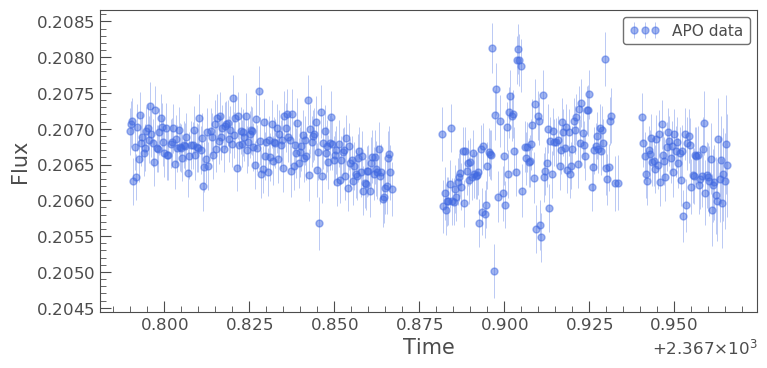

In [5]:
flux = np.array(data['rel_flux_T1'])
error = np.array(data['rel_flux_err_T1'])*err_kludge #inflates the error bars to give a best fit chi2=1
times = np.array(data['BJD_TDB'])
airmass = np.array(data['AIRMASS'])

offset = 2457000
times = times-offset # This is just a constant offset to make the x-axis more readable

lc = LightCurve(time = times, flux = flux, flux_err = error)#.remove_outliers(sigma=3)

lc.errorbar(alpha=0.5,color='royalblue',label=observatory+' data',marker='o',
            markersize='5',normalize=False)

Now let's turn this into a **lightkurve** object

## **The following cell is where you should define all of the specific parameters for the system you are studying. After specifying all of these parameters, the rest of the code should work without fiddling.**

In [6]:
planet_period = np.array(params['P (days)'][index]) # must be in days
planet_radius = params['Rp/R*'][index] # Rp/R*
Epoch = params['Epoch'][index] 
planet_a = params['a/R*'][index] # a/R*
planet_b = params['b'][index] # impact parameter
planet_duration = params['Dur'][index] #hours
ppm_depth = params['Depth'][index] #ppm

planet_i = np.arccos(planet_b/planet_a)*180/np.pi #inclination in degrees
C1 = np.median(lc.flux) #C1 and C2 are the airmass correction parameters
C2 = 0.0
depth = C1*(1-float(ppm_depth)/1e6)

star_teff = params['T_eff'][index] # K
star_met = params['Met'][index] # metallicity
star_g = params['logg'][index] # log g
star_radius = params['R_s'][index] #R*/Rsun

n = np.linspace(0,999,1000)
mid_transit_times = (planet_period*n) + np.array(Epoch)


for i in range(len(n)):
    if (mid_transit_times[i] >= lc.time[0]-1):
        if (mid_transit_times[i] <= lc.time[-1]+1):
            
            expected_t0 = mid_transit_times[i]
            print(f"Anticipated mid-transit time = {expected_t0:.6f}")
            print(f"Anticipated depth = {depth:.4f}")

Anticipated mid-transit time = 2367.818618
Anticipated depth = 0.2063


In [7]:
(((expected_t0-Epoch)/planet_period)*0.000385) # Propagated uncertainty

0.013860000000000004

In [14]:
(expected_t0-Epoch)/planet_period

36.000000000000014

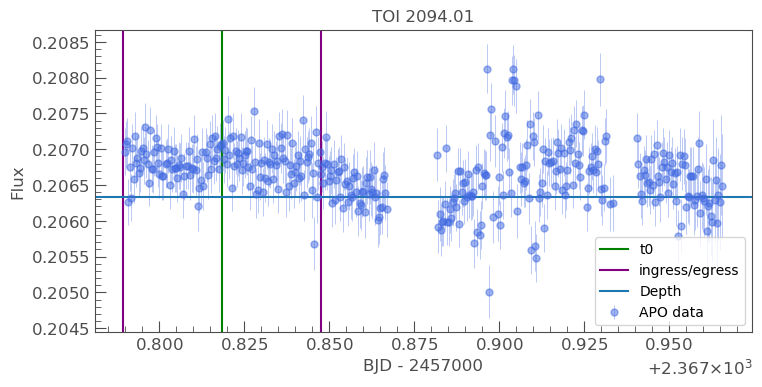

In [8]:
lc.errorbar(alpha=0.5,color='royalblue',label=observatory+' data',marker='o',markersize='5',
           normalize=False)
plt.title('TOI {}'.format(toi))
plt.xlabel('BJD - {}'.format(offset),fontsize=12)
plt.ylabel('Flux',fontsize=12)
plt.axvline(expected_t0,label='t0',color='g')
plt.axvline(expected_t0-(planet_duration/24.0)/2.0,label='ingress/egress',color='purple')
plt.axvline(expected_t0+(planet_duration/24.0)/2.0,color='purple')
plt.axhline(depth,label='Depth')
plt.legend()
plt.savefig('Figs/TOI_{}_NoFit.png'.format(toi))
plt.show()

In [12]:
# star_met = 0.00
# LD_coeff, LD_err = Limb_Dark(Teff = star_teff, log_g = star_g, met = star_met)
# LD = LD_coeff[0]
# print(LD_coeff)
# print('--------')
# print(LD_err)

#LD = [0.6601,0.31006] #This is for TIC 348538431
#LD = [0.67528,0.25598] #This is for TIC 5868998
#LD = [0.70147,0.022237] #This is for TIC 220479565
#LD = [0.65655,0.32989] #This is for TIC 272086159
LD = [0.3050, 0.2898] #This is for TOI 2094.01, using same as TOI 122 as an approximation

The next cell is used to test that lnprob is working properly. If you feed it the expected arguments for Rp and t$_0$, it should spit out a reasonable (read: fininte and non-negative) probability value and an appropriate looking model overlaid on the data.

8134.14437970267


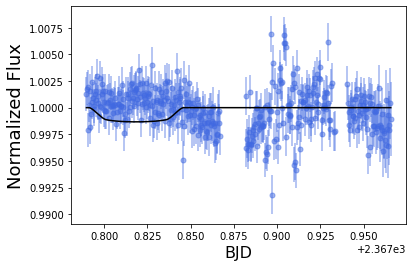

In [13]:
theta = [C1, C2, planet_radius, expected_t0, planet_a, planet_i]
static_params = [planet_radius, planet_period, planet_a, planet_i,
                 expected_t0, LD, offset, observatory, airmass, toi]

a = lnprob(theta, lc, planet_period, LD, airmass, planet_a, expected_t0, plot = True)
print(a)

Now we are ready to define and run an MCMC, using Dan Foreman-Mackey's [emcee](http://dfm.io/emcee/current/):

In [ ]:
# intialize some walkers
ndim, nwalkers, nsteps = 6, 100, 40000
burnin = int(0.3*nsteps)

# these are initial parameters
C1_init = np.random.uniform(C1, C1, nwalkers)
C2_init = np.random.uniform(0.0,0.000001, nwalkers)
Rp_init = np.random.uniform(planet_radius-0.0001, planet_radius+0.0001, nwalkers)
t0_init = np.random.uniform(expected_t0+0.04,expected_t0+0.07, nwalkers)
a_init = np.random.uniform(planet_a-0.005, planet_a+0.005, nwalkers)
i_init = np.random.uniform(planet_i-0.005, planet_i+0.005, nwalkers)

labels = ['C1','C2','Rp/R*','T0','a/R*','i (deg)'] #this is for the corner plot

p0 = np.transpose([C1_init, C2_init, Rp_init, t0_init, a_init, i_init])

In [ ]:
# create a sampler and run it
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = (lc,planet_period,LD,airmass,planet_a, expected_t0))
result = sampler.run_mcmc(p0, nsteps)

In [ ]:
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T
C1_sam, C2_sam, Rp_sam, t0_sam, A_sam, Inc_sam = samples

sig1_C1 = np.percentile(C1_sam, [16., 50., 84.])
sig1_C2 = np.percentile(C2_sam, [16., 50., 84.])
sig1_Rp = np.percentile(Rp_sam, [16., 50., 84.])
sig1_t0 = np.percentile(t0_sam, [16., 50., 84.])
sig1_A = np.percentile(A_sam, [16., 50., 84.])
sig1_Inc = np.percentile(Inc_sam, [16., 50., 84.])

parameters = [sig1_C1[1],sig1_C2[1],sig1_Rp[1],sig1_t0[1],sig1_A[1],sig1_Inc[1]]

best_fit_model = (sig1_C1[1] + sig1_C2[1]*(airmass-1))*BATMAN(P = planet_period,Rp = sig1_Rp[1],
                                                              t0 = sig1_t0[1],
                                                              inc = sig1_Inc[1],
                                                              A = sig1_A[1], LD = LD,
                                                              t = lc.time)
reduced_chisq = np.sum((lc.flux - best_fit_model)**2/(lc.flux_err)**2)/(len(lc.flux)-4)     
err_kludge = np.sqrt(reduced_chisq)
print(err_kludge)

np.savetxt(fname=f'Data/TOI_{toi}_samples.txt',X=samples)

In [ ]:
light_curve(lc, parameters, sampler, static_params, nsteps, Epoch, tic_id)

In [ ]:
plot_chain(sampler, static_params, start=burnin, stop=nsteps)

In [ ]:
#corner(samples, labels, toi)

In [ ]:
for i in range(len(samples)):
    tau_f = emcee.autocorr.integrated_time(samples[i])
    print((nsteps-burnin)/tau_f)

In [ ]:
rms_plot(lc, parameters, static_params)

In [ ]:
print('C1 = {:.5f}'.format(sig1_C1[1]),
      '+ {:.5f}'.format(sig1_C1[2]-sig1_C1[1]),
      '- {:.5f}'.format(sig1_C1[1]-sig1_C1[0]))

print('C2 = {:.5f}'.format(sig1_C2[1]),
      '+ {:.5f}'.format(sig1_C2[2]-sig1_C2[1]),
      '- {:.5f}'.format(sig1_C2[1]-sig1_C2[0]))

print('Flux Deficit at Mid-Transit = {:.3f} ppt'.format((
      1-np.amin(best_fit_model/(sig1_C1[1] + sig1_C2[1]*(airmass-1))))*1000))

print('Rp/R* = {:.4f}'.format(sig1_Rp[1]),
      '+ {:.4f}'.format(sig1_Rp[2]-sig1_Rp[1]),
      '- {:.4f}'.format(sig1_Rp[1]-sig1_Rp[0]))

print('Rp (R_E) = {:.3f}'.format(sig1_Rp[1]*star_radius*109.168),
      '+ {:.3f}'.format((sig1_Rp[2]-sig1_Rp[1])*star_radius*109.168),
      '- {:.3f}'.format((sig1_Rp[1]-sig1_Rp[0])*star_radius*109.168))

print('a/R* = {:.3f}'.format(sig1_A[1]),
      '+ {:.3f}'.format(sig1_A[2]-sig1_A[1]),
      '- {:.3f}'.format(sig1_A[1]-sig1_A[0]))

print('Inclination (Deg) = {:.3f}'.format(sig1_Inc[1]),
      '+ {:.3f}'.format(sig1_Inc[2]-sig1_Inc[1]),
      '- {:.3f}'.format(sig1_Inc[1]-sig1_Inc[0]))

print('Impact parameter (b) = {:.3f}'.format(np.cos((sig1_Inc[1])*np.pi/180)*sig1_A[1]))

print('Mid-Transit Time = {:.6f}'.format(offset+sig1_t0[1]),
      '+ {:.6f}'.format(sig1_t0[2]-sig1_t0[1]),
      '- {:.6f}'.format(sig1_t0[1]-sig1_t0[0]))

print(f"Anticipated mid-transit time = {(offset+expected_t0):.6f}")

print(f"duration = {planet_period/(2*np.pi)/(sig1_A[1])*24:.3f} hours")

results = Table({'rp':[sig1_Rp[1]],
                 'drp':[sig1_Rp[1]-sig1_Rp[0]],
                 't0':[sig1_t0[1]],
                 'dt0':[sig1_t0[1]-sig1_t0[0]],
                 'a':[sig1_A[1]],
                 'da':[sig1_A[1]-sig1_A[0]],
                 'i':[sig1_Inc[1]],
                 'di':[sig1_Inc[1]-sig1_Inc[0]]},
                names=['rp','drp','t0','dt0','a','da','i','di'])
ascii.write(results,f'Data/TOI_{toi}_bestfitparams.txt')